In [25]:
import re
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import numpy
import csv

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import multi_gpu_model
from keras.layers import Dense, Activation, Dropout




def sequenceGenres():
    f = open(r'./Basic_DATA/Movie_Genres.tsv', 'r', encoding='utf-8')
    rdr = csv.reader(f, delimiter='\t')

    #영화, 출력 tconst, 출력 장르값
    movie, output_tconst, output_genres = [] ,[], []
    for i in rdr:
        movie.append(i)

    for i in range(movie.__len__()):
    #   if movie[i][1].find("Horror") == -1 and movie[i][1].find("Romance")>=0:

        if movie[i][1].find("Horror") >= 0:
            output_tconst.append(movie[i][0])
            output_genres.append(movie[i][1])
    
    print(output_tconst.__len__(), output_genres.__len__())
    
    return output_tconst, output_genres

# 트레인과 테스트 쓸모없는 값을 제거하는 단입니다, 현재 불용어를 제거하지 않은 상태입니다 (Movie, File)
# 불용어를 제거하게 되면     t = Tokenizer(num_words=1000) 값을 더 줄이더라도 유의미한 값을 얻을 수 있을 것으로 예상됩니다.
# t = Tokenizer(num_words=1000) 값을 줄이게 되면 GPU의 메모리 부하량이 줄어듭니다.
#추 후 라이브러리를 통해 불용어를 제거할 예정입니다.
def garbage_remove(tconst):
    train = pd.read_csv(r'./Action set/Action.csv', skiprows=1, names=['Text', 'sentiment'])
    test = pd.read_csv(r"./Web_Crowling/" + tconst + ".tsv",sep='\t', names=['Rank', 'ID', 'Title','Text','sentiment'])
    print(tconst)
    A, B = [], []

    for i in train['Text']:
        i = re.sub('[^a-zA-Z0-9 \n]', '', str(i))
        i = i.replace("br","").replace("  "," ").replace("   "," ")
        A.append(i)

    for i in test['Text']:
        i = re.sub('[^a-zA-Z0-9 \n]', '', str(i))
        i = i.replace("br","").replace("  "," ").replace("   "," ")
        B.append(i)

    train['Text'] = A
    test['Text'] = B
    return train,test


#쓰레기 값을 제거한 데이터들에 대해서, 백터화-웟 핫 인코딩을 한 뒤, 반환합니다.
def preprocessing(garbage_remove):
    t = Tokenizer(num_words=1250)
    train,test = garbage_remove
    test_label, train_label = [], []

    t.fit_on_texts(train['Text'])
    t.fit_on_texts(test['Text'])

    #cruel = 1, astonish = 0 로 설정합니다.
    for i in train['sentiment']:
        if i == 'fantasy':
            train_label.append(0)
        elif i == 'reality':
            train_label.append(1)
        elif i == 'intelligence':
            train_label.append(2)
        else:
            train_label.append(3)
    
    #(이 부분 고려 필요) test_label 을 모두 cruel 로 설정, 정확도가 떨어질수록 astonish에 가깝다는 논지로, 상당히 정확합니다.
    # 다만 .h5파일로 저장하여 불러들인뒤, 다른 데이터 셋(B)을 추가하여 확인하면
    # 다른 데이터셋 (B)를 Test 데이터로 둔 것보다 훨신 떨어지는 결과를 얻습니다.

    train_result = t.texts_to_sequences(train['Text'])
    test_result = t.texts_to_sequences(test['Text'])

    # 원 핫 인코딩
    train_result = t.sequences_to_matrix(train_result, mode='binary')
    test_result = t.sequences_to_matrix(test_result, mode='binary')
    return train_result, train_label

#실질적인 모델 구성입니다. CNN 모델로 수성되어 있습니다
def AI(preprocessing):
    X_train,y_train = preprocessing
    num_classes = numpy.max(y_train) + 1


    top_words = 2000
    max_words = 1250
    # amx_words 를 1000 이상으로 설정해 주어야 비교적 정확한 값을 얻을 수 있습니다. 임의적으로 줄이면 그래픽카드 메모리가 적어도 상관은 없지만.
    # 30~70 사이의 값은 잔차가 굉장히 많이 튀게 됩니다.
    # create the model
    model = Sequential()
    model.add(Dense(512, input_shape=(max_words,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='accuracy', min_delta=0, patience=3, verbose=0, mode='auto') # 조기종료 콜백함수 정의
    hist = model.fit(X_train, y_train,
                        batch_size=64,
                        epochs=50,
                        verbose=1,
                        validation_split=0.1)


    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    return scores


def write(tconst, genres, scores):
    f = open(r"./Basic_DATA/Horror.tsv", 'a', encoding='UTF8')
    data = str(tconst) + "\t" + str(genres) + "\t" + "Horror" + "\t" + str(numpy.round(scores[1]*100,2)) + "\n"
    print("data = ",data)
    f.write(data)
    f.close()



# score = AI(preprocessing(garbage_remove()))
# TCONST,GENRES = sequenceGenres()

tconst = "tt4154756"
genres = "action"
scores = AI(preprocessing(garbage_remove(tconst)))
keras.backend.clear_session()
write(tconst, genres, scores)

tt4154756


KeyboardInterrupt: 

                                                post          tags
0  robert ludlum is one of my favorite spy storie...  intelligence
1  at the end of his career renegade and brillian...         cruel
2  despite the fact that i am a big momoa fan and...       fantasy
3  its funny how summer movies play out over time...  intelligence
4  deserves more credit and attention but it like...  intelligence
5  bryan singer said that this movie was driven b...       fantasy
6  i saw the departed before watching and i unfor...  intelligence
7  im going to keep it short  some people find a ...       reality
8  luc bessons was one of the most stylish action...  intelligence
9  i had a lovehate relationship with vol 1 now t...         cruel
2493295


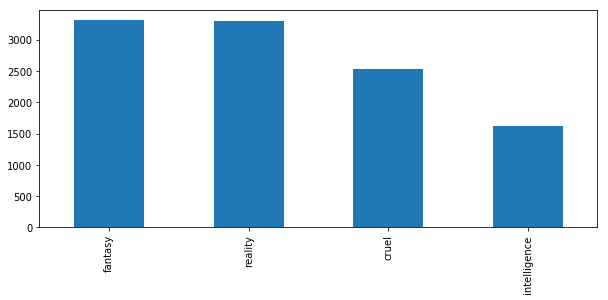

In [13]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

my_tags = ['fantasy','reality','intelligence','cruel']
df = pd.read_csv('./Action set/Action.csv')
df = df[pd.notnull(df['tags'])]
print(df.head(10))
print(df['post'].apply(lambda x: len(x.split(' '))).sum())

plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

In [16]:
# Text Pre-Prosessing 

def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])
print_plot(10)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)
print_plot(10)


X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

summer another action film morgan freeman usually associated action movies fits one latest stint much better dark knight proves film strong dark knight proves action good walks dark knight sprints finish line plot spoiler guardian group operating 1000 years assassinating people according orders mysterious source higher enough hold together excitement film lots action sceneswesley enlisted group early movie told father killed breaks dull humdrum office account manager job exciting world beaten killing peoplehe dumps younger chick girlfriend older tattooed woman angela jolie thats ok young one doesnt really seem interested plenty interested friendsoverall action top notch though wonder car crash sequences much gasoline would cost imagine gas cheaper filmed cast ok many summer action films last years major plot twist wesley late film leave viewers find one good thing plot makes sense even though circumstances stretch sometimes seems go little farthis film ok good flick drivein theaters wo

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.790272614622057
              precision    recall  f1-score   support

     fantasy       0.99      0.71      0.82       764
     reality       0.90      0.94      0.92      1014
intelligence       1.00      0.25      0.40       490
       cruel       0.62      0.97      0.76       960

   micro avg       0.79      0.79      0.79      3228
   macro avg       0.88      0.72      0.73      3228
weighted avg       0.85      0.79      0.77      3228



In [15]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.9132589838909542
              precision    recall  f1-score   support

     fantasy       0.95      0.88      0.91       764
     reality       0.90      0.96      0.93      1014
intelligence       0.98      0.89      0.93       490
       cruel       0.88      0.90      0.89       960

   micro avg       0.91      0.91      0.91      3228
   macro avg       0.92      0.91      0.92      3228
weighted avg       0.92      0.91      0.91      3228



In [18]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .7)
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 6777 samples, validate on 754 samples
Epoch 1/20
6777/6777 [==============================] - 2s 264us/step - loss: 0.5541 - acc: 0.8023 - val_loss: 0.2950 - val_acc: 0.8992
Epoch 2/20
6777/6777 [==============================] - 1s 219us/step - loss: 0.2386 - acc: 0.9193 - val_loss: 0.2895 - val_acc: 0.8966
Epoch 3/20
6777/6777 [==============================] - 1s 220us/step - loss: 0.1662 - acc: 0.9447 - val_loss: 0.2930 - val_acc: 0.8952
Epoch 4/20
6777/6777 [==============================] - 1s 220us/step - loss: 0.1212 - acc: 0.9612 - val_loss: 0.3205 - val_acc: 0.8820
Epoch 5/20
6777/6777 [==============================] - 2s 224us/step - loss: 0.0919 - acc: 0.9743 - val_loss: 0.3193 - val_acc: 0.8846
Epoch 6/20
6777/6777 [================

In [30]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

3228/3228 [==============================] - 0s 28us/step
Test accuracy: 0.8708178440877496
